In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
#####################
#LINEAR POLARIZATION#
#####################
from numba.pycc import CC
from photon_linear import *
import numpy as np
from numba import typed, types
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from plot import *
from numpy import genfromtxt
from numba.cuda.random import init_xoroshiro128p_states
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib import cm
from scipy import optimize
from tqdm.notebook import trange, tqdm
import time
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2

def fit_func(x, const, a, b, c, d):
    return np.power(x, 3) * d + np.power(x, 2) * c + np.power(x, 2) * b + x * a + const

def make_dir(dir_name):
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
        
gridDim = 1
blockDim = 128
dim = gridDim * blockDim
all_adj_dist = []
all_collected = []
all_amps = []
all_modes = []
mode = 1.0
iters = 3 * 16
iters =64
NNxy = 500
NNr = int(NNxy/2)
NNz = int(NNxy/2)
degree_divs = 64
n_steps=20
n_sims=4
timers=[]
dataset_path = 'data/Linear 6'

np.random.seed(4)
s1 = genfromtxt(f's1_pm_{degree_divs}.txt', delimiter=',')
s2 = genfromtxt(f's2_pm_{degree_divs}.txt', delimiter=',')
m11 = genfromtxt(f'm11_pm_{degree_divs}.txt', delimiter=',')
m12 = genfromtxt(f'm12_pm_{degree_divs}.txt', delimiter=',')
temp = 1j * s1[:, 2]
temp += s1[:, 1]
s1 = temp
temp = 1j * s2[:, 2]
temp += s2[:, 1]
s2 = temp
m11 = m11[:, 1]
m12 = m12[:, 1]

s1 = np.ascontiguousarray(s1)
s2 = np.ascontiguousarray(s2)
m11 = np.ascontiguousarray(m11)
m12 = np.ascontiguousarray(m12)
cuda.pinned(s1)
cuda.pinned(s2)
cuda.pinned(m11)
cuda.pinned(m12)

co_xy_all = np.zeros((dim, NNxy, NNxy), dtype=np.float32)
co_rz_all = np.zeros((dim, NNr, NNz), dtype=np.float32)
co_rz_trad_all = np.zeros((dim, NNr, NNz), dtype=np.float32)
incoh_cross_xy_all=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
incoh_cross_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
cross_xy_all=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
cross_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
# i_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
# q_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
# u_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
# v_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
reflection_all=np.zeros((dim), dtype=np.float32)
zstokes_all   =np.zeros((dim, NNz,3), dtype=np.float32)

ctr = 0
ctr_trad = 0
ctr_cross=0

make_dir(dataset_path)
make_dir(os.path.join(dataset_path,'co'))
make_dir(os.path.join(dataset_path,'cross'))
make_dir(os.path.join(dataset_path,'incoh'))
make_dir(os.path.join(dataset_path,'reflection'))
make_dir(os.path.join(dataset_path,'zstokes'))
# incident_degrees=[1,10,20,30,40,50,60,70,80,85,89]
incident_degrees=[10,50,80,85,89]
for i in range(1):
    n_e=1.33
    print(f'####SIMULATION {i+1}######')
    # incident_degree=incident_degrees[i]
    incident_degree=incident_degrees[4]
    for j in trange(iters, desc='1st loop'):
        time1=time.time()
        mode = i % 3
        mode =3
        random_nums=np.random.rand(dim, n_steps * 10)
        d_amplitudes =        cuda.to_device(np.ones(dim, dtype=np.float32))
        d_steps =             cuda.to_device(np.zeros(dim, dtype=np.float32))
        d_lengths =           cuda.to_device(np.zeros(dim, dtype=np.float32))
        d_direction_theta =   cuda.to_device(np.ones(dim, dtype=np.float32) * (np.pi / 2))
        d_maxZs =             cuda.to_device(np.zeros(dim, dtype=np.float32))
        d_position_x =        cuda.to_device(np.zeros(dim, dtype=np.float32))
        d_position_y =        cuda.to_device(np.ones(dim, dtype=np.float32) * (1e-8))
        d_polarization =      cuda.to_device(np.ones(dim, dtype=np.float32))
        d_adjusted_dist =     cuda.to_device(np.zeros(dim, dtype=np.float32))
        d_collected =         cuda.to_device(np.zeros(dim, dtype=np.float32))
        d_modes =             cuda.to_device(np.ones(dim, dtype=np.float32) * mode)
    
        d_jones =             cuda.to_device(np.zeros((dim, 4), dtype=np.complex64))
        d_jones_partial =     cuda.to_device(np.zeros((dim, 4), dtype=np.complex64))
        d_U =                 cuda.to_device(np.zeros((dim, 3), dtype=np.float32))
        d_W =                 cuda.to_device(np.zeros(dim, dtype=np.float32))
        d_mu_as =             cuda.to_device(np.ones(dim, dtype=np.float32) * 0)
        d_mu_ss =             cuda.to_device(np.ones(dim, dtype=np.float32) * np.float(100))
        d_scat_events =       cuda.to_device(np.zeros(dim, dtype=np.float32))
        d_co_xy =             cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
        d_cross_xy =          cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
        d_incoh_cross_xy =    cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
        d_co_rz =             cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
        d_cross_rz =          cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
        d_incoh_cross_rz =    cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
        d_co_xy_trad =        cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
        d_cross_xy_trad =     cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
        d_incoh_cross_xy_trad=cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
        d_co_rz_trad =        cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
        d_cross_rz_trad =     cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
        d_incoh_cross_rz_trad=cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
        d_position =          cuda.to_device(np.zeros((NNxy, 3), dtype=np.float32))
        # d_i_stokes_rz=        cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
        # d_q_stokes_rz =       cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
        # d_u_stokes_rz =       cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
        # d_v_stokes_rz =       cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
        d_random_nums =       cuda.to_device(random_nums)
        rng_states=1
        d_reflection =       cuda.to_device(np.zeros((dim, 2), dtype=np.float32))
        d_zstokes    =       cuda.to_device(np.zeros((dim, NNz,3), dtype=np.float32)) #co\incoh cross\cross
        seed = j
    
        process_steps_linear[gridDim, blockDim](seed, incident_degree,n_e,d_reflection,d_zstokes, rng_states , d_modes, d_random_nums, d_U, d_W, d_jones, d_mu_as, d_mu_ss, d_scat_events, d_jones_partial, d_co_xy, d_cross_xy, d_incoh_cross_xy, d_co_rz, d_cross_rz, d_incoh_cross_rz, d_co_xy_trad, d_cross_xy_trad, d_incoh_cross_xy_trad, d_co_rz_trad, d_cross_rz_trad, d_incoh_cross_rz_trad, d_position, s1, s2, m11, m12)
     
        co_xy=d_co_xy.copy_to_host()
        cross_xy=d_cross_xy.copy_to_host()
        incoh_cross_xy=d_incoh_cross_xy.copy_to_host()
        co_rz=d_co_rz.copy_to_host()
        cross_rz=d_cross_rz.copy_to_host()
        incoh_cross_rz=d_incoh_cross_rz.copy_to_host()
        co_xy_trad=d_co_xy_trad.copy_to_host()
        cross_xy_trad=d_cross_xy_trad.copy_to_host()
        incoh_cross_xy_trad=d_incoh_cross_xy_trad.copy_to_host()
        co_rz_trad=d_co_rz_trad.copy_to_host()
        cross_rz_trad=d_cross_rz_trad.copy_to_host()
        incoh_cross_rz_trad=d_incoh_cross_rz_trad.copy_to_host()
        position=d_position.copy_to_host()
        # i_stokes_rz = d_i_stokes_rz.copy_to_host()
        # q_stokes_rz = d_q_stokes_rz.copy_to_host()
        # u_stokes_rz = d_u_stokes_rz.copy_to_host()
        # v_stokes_rz = d_v_stokes_rz.copy_to_host()
        reflections=d_reflection.copy_to_host()
        zstokes   =d_zstokes.copy_to_host()
     
        # i_stokes_rz_all+=i_stokes_rz
        # q_stokes_rz_all+=q_stokes_rz
        # u_stokes_rz_all+=u_stokes_rz
        # v_stokes_rz_all+=v_stokes_rz
        reflections[reflections[:,0]==0]=1
        reflection_all+=reflections[:,1]/reflections[:,0]
        zstokes_all[:,:,0]+= zstokes[:,:,0]/reflections[:,0,np.newaxis]
        zstokes_all[:,:,1]+= zstokes[:,:,1]/reflections[:,0,np.newaxis]
        zstokes_all[:,:,2]+= zstokes[:,:,2]/reflections[:,0,np.newaxis]
        if not(np.isnan(co_rz.max())):
            co_rz_all += co_rz
            co_xy_all += co_xy  
            
            ctr+=1
            print(ctr, 'partial',co_rz.max())
        if not(np.isnan(co_rz_trad.max())):
            co_rz_trad_all+=co_rz_trad
            ctr_trad+=1
            print(ctr_trad, 'trad',co_rz_trad.max())
            
        if not (np.isnan(incoh_cross_xy_all.max())):
            incoh_cross_xy_all+=incoh_cross_xy        
            
            incoh_cross_rz_all+=incoh_cross_rz      
            ctr_cross+=1
        if not (np.isnan(cross_xy_all.max())):
            cross_xy_all+=cross_xy
            cross_rz_all+=cross_rz
            
        time2=time.time()
        timers.append(time2-time1)
    
    vars=[co_rz_all,cross_rz_all,incoh_cross_rz_all,reflection_all,zstokes_all]
    folders=['co','cross','incoh','reflection','zstokes']
    var_names=[f'co_rz_linear_{incident_degree}.npy',f'cross_rz_linear_{incident_degree}.npy',f'incoh_cross_linear_{incident_degree}.npy',f'reflection_{incident_degree}.npy',f'zstokes{incident_degree}.npy']
    full_paths=[]
    for i in range(5):
        full_paths.append(os.path.join(dataset_path,folders[i],var_names[i]))
    i=0
    for var, path in zip(vars, full_paths):
        np.save(path,var)
        print('saveing',folders[i])
        i+=1
    with open(os.path.join(dataset_path,'params.txt'),'a') as f:
        f.writelines(f'{i},{n_e}\n')

####SIMULATION 1######
1 partial 4.031447
1 trad 0.0
2 partial 4.945854
2 trad 0.0
3 partial 9.849595
3 trad 0.0
4 partial 4.447531
4 trad 0.0
5 partial 3.6371343
5 trad 0.0
6 partial 9.383508
6 trad 0.0
7 partial 2.8238807
7 trad 0.0
8 partial 3.700245
8 trad 0.0
9 partial 4.7165103
9 trad 0.0
10 partial 9.351056
10 trad 0.0
11 partial 2.352429
11 trad 0.0
12 partial 1.9481984
12 trad 0.0
13 partial 2.1123095
13 trad 0.0
14 partial 3.3182068
14 trad 0.0
15 partial 4.406314
15 trad 0.0
16 partial 4.115556
16 trad 0.0
17 partial 3.1073518
17 trad 0.0
18 partial 3.604394
18 trad 0.0
19 partial 6.9668
19 trad 0.0
20 partial 3.1931655
20 trad 0.0
21 partial 6.712282
21 trad 0.0
22 partial 1.7523216
22 trad 0.0
23 partial 1.6957785
23 trad 0.0
24 partial 4.7694707
24 trad 0.0
25 partial 1.6797
25 trad 0.0
26 partial 2.664009
26 trad 0.0
27 partial 3.079847
27 trad 0.0
28 partial 3.5979168
28 trad 0.0
29 partial 4.3645144
29 trad 0.0
30 partial 6.3835864
30 trad 0.0
31 partial 4.2041464
31 t

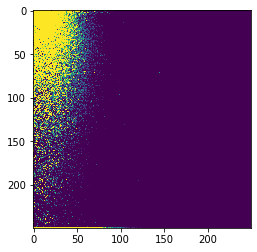

In [2]:
grid_size=NNr
x = np.sum(co_rz_all, axis=0)
# print(x[NNr-1,NNr-1])
x=np.abs(x)

x[grid_size-1,grid_size-1]=0
x[grid_size-2,grid_size-2]=0

x=(x-x.mean())/x.std()
# x_clipped=x/x.max()
x_clipped=np.clip(x,0,1)
plt.imshow(x_clipped)
# plt.savefig('co_linear_4m.png')
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


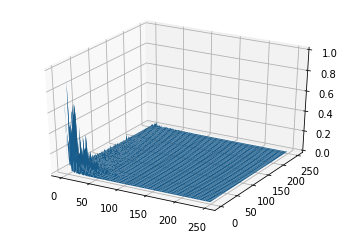

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%load_ext autoreload
%autoreload 2

grid_size = NNr
x = np.sum(co_rz_all, axis=0)
x[0,0]=0
x[grid_size-1,grid_size-1]=0
x=x/x.max()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(grid_size), range(grid_size))  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X, Y, x)
ax.set_zlim(0, 1)
plt.show()


In [3]:
#SAVE
import numpy as np
import os

dx=4e-4
dr=dx
no=1.33
ne=1.33
chi=0
SAVEDIR='data'
if not os.path.isdir(os.path.join(SAVEDIR)):
    os.mkdir(SAVEDIR)
vars=[     
co_xy_all ,
co_rz_all ,
co_rz_trad_all ,
incoh_cross_xy_all ,
incoh_cross_rz_all ,
cross_xy_all ,
cross_rz_all ,
# i_stokes_rz_all ,
# q_stokes_rz_all ,
# u_stokes_rz_all ,
# v_stokes_rz_all 
]
vars_names=[
'co_xy_all',
'co_rz_all',
'co_rz_trad_all',
'incoh_cross_xy_all',
'incoh_cross_rz_all',
'cross_xy_all',
'cross_rz_all',
# 'i_stokes_rz_all',
# 'q_stokes_rz_all',
# 'u_stokes_rz_all',
# 'v_stokes_rz_all'
]
for var, var_name in zip(vars,vars_names):
    np.save(os.path.join(SAVEDIR,var_name+'.npy'),var)

params=[NNxy,NNr,NNz,iters,dx,dr,dim,no,ne,]  
params_names=['NNxy','NNr','NNz','iters','dx','dr','dim','no','ne','chi']  
with open(os.path.join(SAVEDIR,'params.txt'),'w') as f:
    for param, param_name in zip(params, params_names):
        f.writelines(param_name+'='+str(param))



In [1]:
#LOAD Linear
import numpy as np
import os
#LOAD linear 
#linear address
LOADDIR='data'
dim=128
NNxy=500
NNr=250
NNz=NNr
vars_names=[
'co_xy_all',
'co_rz_all',
'incoh_cross_xy_all',
'incoh_cross_rz_all',
'cross_xy_all',
'cross_rz_all'
]
co_xy_linear = np.zeros((dim, NNxy, NNxy), dtype=np.float32)
co_rz_linear = np.zeros((dim, NNr, NNz), dtype=np.float32)
incoh_cross_xy_linear=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
incoh_cross_rz_linear=np.zeros((dim, NNr, NNz), dtype=np.float32)
cross_xy_linear=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
cross_rz_linear=np.zeros((dim, NNr, NNz), dtype=np.float32)
 
vars=[co_xy_linear,co_rz_linear,incoh_cross_xy_linear,incoh_cross_rz_linear,cross_xy_linear,cross_rz_linear]

for i, var_name in enumerate(vars_names):
    vars[i][:,:,:]=np.load(os.path.join(LOADDIR,var_name+'.npy'))



In [9]:
co_xy_all=co_rz_linear
grid_size=NNxy
x = np.sum(co_xy_all, axis=0)
x[0,0]=0
x[grid_size-1,grid_size-1]=0
x=(x-x.mean())/x.std()
x_clipped=x/x.max()
x_clipped=np.clip(x,0,1)
plt.imshow(x_clipped)
# plt.savefig('co_linear_4m.png')
plt.show()

IndexError: index 499 is out of bounds for axis 0 with size 250

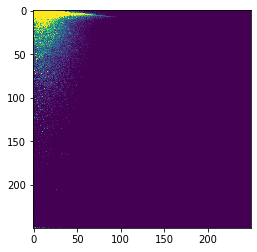

In [11]:
grid_size=NNr
x = np.sum(co_rz_linear, axis=0)
x[0,0]=0
x[grid_size-1,grid_size-1]=0
x=(x-x.mean())/x.std()
x_clipped=x/x.max()
x_clipped=np.clip(x,0,1)
plt.imshow(x_clipped)
# plt.savefig('co_linear_4m.png')
plt.show()

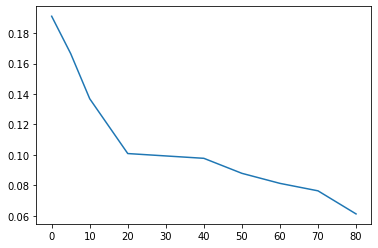

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

root='data'
NNxy=500
co_xy_0d = np.mean(np.load(os.path.join(root,'data18 linear 0deg','co_xy_all.npy')), axis=0)
co_xy_5d = np.mean(np.load(os.path.join(root,'data17 linear 5deg','co_xy_all.npy')), axis=0)
co_xy_10d = np.mean(np.load(os.path.join(root,'data16 linear 10deg','co_xy_all.npy')), axis=0)
co_xy_20d = np.mean(np.load(os.path.join(root,'data15 linear 20deg','co_xy_all.npy')), axis=0)
co_xy_40d = np.mean(np.load(os.path.join(root,'data14 linear 40deg','co_xy_all.npy')), axis=0)
co_xy_50d = np.mean(np.load(os.path.join(root,'data13 linear 50deg','co_xy_all.npy')), axis=0)
co_xy_60d = np.mean(np.load(os.path.join(root,'data12 linear 60deg','co_xy_all.npy')), axis=0)
co_xy_70d = np.mean(np.load(os.path.join(root,'data11 linear 70deg','co_xy_all.npy')), axis=0)
co_xy_80d = np.mean(np.load(os.path.join(root,'data10 linear 80deg','co_xy_all.npy')), axis=0)

co_sum_0d = np.sum(co_xy_0d[1:,1:])
co_sum_5d = np.sum(co_xy_5d[1:,1:])
co_sum_10d = np.sum(co_xy_10d[1:,1:])
co_sum_20d = np.sum(co_xy_20d[1:,1:])
co_sum_40d = np.sum(co_xy_40d[1:,1:])
co_sum_50d = np.sum(co_xy_50d[1:,1:])
co_sum_60d = np.sum(co_xy_60d[1:,1:])
co_sum_70d = np.sum(co_xy_70d[1:,1:])
co_sum_80d = np.sum(co_xy_80d[1:,1:])

x=[0,5,10,20,40,50,60,70,80]
data=[co_sum_0d,co_sum_5d,co_sum_10d,co_sum_20d,co_sum_40d,co_sum_50d,co_sum_60d,co_sum_70d,co_sum_80d]
sum_all=np.sum(data)

plt.plot(x,data/sum_all)
plt.show()

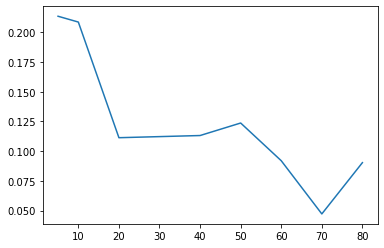

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

root='data'
NNxy=500
co_xy_5d = np.mean(np.load(os.path.join(root,'data17 linear 5deg','co_xy_all.npy')), axis=0)
co_xy_10d = np.mean(np.load(os.path.join(root,'data16 linear 10deg','co_xy_all.npy')), axis=0)
co_xy_20d = np.mean(np.load(os.path.join(root,'data15 linear 20deg','co_xy_all.npy')), axis=0)
co_xy_40d = np.mean(np.load(os.path.join(root,'data14 linear 40deg','co_xy_all.npy')), axis=0)
co_xy_50d = np.mean(np.load(os.path.join(root,'data13 linear 50deg','co_xy_all.npy')), axis=0)
co_xy_60d = np.mean(np.load(os.path.join(root,'data12 linear 60deg','co_xy_all.npy')), axis=0)
co_xy_70d = np.mean(np.load(os.path.join(root,'data11 linear 70deg','co_xy_all.npy')), axis=0)
co_xy_80d = np.mean(np.load(os.path.join(root,'data10 linear 80deg','co_xy_all.npy')), axis=0)

co_ss_5d =  np.sum( co_xy_5d[0,0])
co_ss_10d = np.sum(co_xy_10d[0,0])
co_ss_20d = np.sum(co_xy_20d[0,0])
co_ss_40d = np.sum(co_xy_40d[0,0])
co_ss_50d = np.sum(co_xy_50d[0,0])
co_ss_60d = np.sum(co_xy_60d[0,0])
co_ss_70d = np.sum(co_xy_70d[0,0])
co_ss_80d = np.sum(co_xy_80d[0,0])

x=[5,10,20,40,50,60,70,80]
data=[co_ss_5d,co_ss_10d,co_ss_20d,co_ss_40d,co_ss_50d,co_ss_60d,co_ss_70d,co_ss_80d]
sum_all=np.sum(data)

plt.plot(x,data/sum_all)
plt.show()

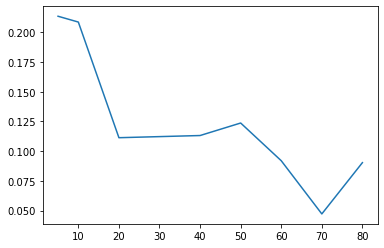

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

root='data'
NNxy=500
NNrz=250
co_rz_5d = np.mean(np.load(os.path.join(root,  'data17 linear 5deg','co_rz_all.npy')), axis=0)
co_rz_10d = np.mean(np.load(os.path.join(root,'data16 linear 10deg','co_rz_all.npy')), axis=0)
co_rz_20d = np.mean(np.load(os.path.join(root,'data15 linear 20deg','co_rz_all.npy')), axis=0)
co_rz_40d = np.mean(np.load(os.path.join(root,'data14 linear 40deg','co_rz_all.npy')), axis=0)
co_rz_50d = np.mean(np.load(os.path.join(root,'data13 linear 50deg','co_rz_all.npy')), axis=0)
co_rz_60d = np.mean(np.load(os.path.join(root,'data12 linear 60deg','co_rz_all.npy')), axis=0)
co_rz_70d = np.mean(np.load(os.path.join(root,'data11 linear 70deg','co_rz_all.npy')), axis=0)
co_rz_80d = np.mean(np.load(os.path.join(root,'data10 linear 80deg','co_rz_all.npy')), axis=0)

co_ss_5d =  np.sum( co_rz_5d[NNrz-1,NNrz-1])
co_ss_10d = np.sum(co_rz_10d[NNrz-1,NNrz-1])
co_ss_20d = np.sum(co_rz_20d[NNrz-1,NNrz-1])
co_ss_40d = np.sum(co_rz_40d[NNrz-1,NNrz-1])
co_ss_50d = np.sum(co_rz_50d[NNrz-1,NNrz-1])
co_ss_60d = np.sum(co_rz_60d[NNrz-1,NNrz-1])
co_ss_70d = np.sum(co_rz_70d[NNrz-1,NNrz-1])
co_ss_80d = np.sum(co_rz_80d[NNrz-1,NNrz-1])

x=[5,10,20,40,50,60,70,80]
data=[co_ss_5d,co_ss_10d,co_ss_20d,co_ss_40d,co_ss_50d,co_ss_60d,co_ss_70d,co_ss_80d]
sum_all=np.sum(data)

plt.plot(x,data/sum_all)
plt.show()


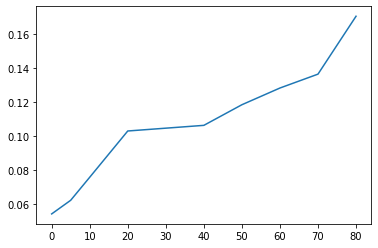

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

root='data'
NNxy=500
NNrz=250
co_rz_0d = np.mean(np.load(os.path.join(root, 'data18 linear 0deg','co_rz_all.npy')), axis=0)
co_rz_5d = np.mean(np.load(os.path.join(root, 'data17 linear 5deg','co_rz_all.npy')), axis=0)
co_rz_10d = np.mean(np.load(os.path.join(root,'data16 linear 10deg','co_rz_all.npy')), axis=0)
co_rz_20d = np.mean(np.load(os.path.join(root,'data15 linear 20deg','co_rz_all.npy')), axis=0)
co_rz_40d = np.mean(np.load(os.path.join(root,'data14 linear 40deg','co_rz_all.npy')), axis=0)
co_rz_50d = np.mean(np.load(os.path.join(root,'data13 linear 50deg','co_rz_all.npy')), axis=0)
co_rz_60d = np.mean(np.load(os.path.join(root,'data12 linear 60deg','co_rz_all.npy')), axis=0)
co_rz_70d = np.mean(np.load(os.path.join(root,'data11 linear 70deg','co_rz_all.npy')), axis=0)
co_rz_80d = np.mean(np.load(os.path.join(root,'data10 linear 80deg','co_rz_all.npy')), axis=0)

co_ss_0d =  np.sum( co_rz_0d[:NNrz-1,:NNrz-1])
co_ss_5d =  np.sum( co_rz_5d[:NNrz-1,:NNrz-1])
co_ss_10d = np.sum(co_rz_10d[:NNrz-1,:NNrz-1])
co_ss_20d = np.sum(co_rz_20d[:NNrz-1,:NNrz-1])
co_ss_40d = np.sum(co_rz_40d[:NNrz-1,:NNrz-1])
co_ss_50d = np.sum(co_rz_50d[:NNrz-1,:NNrz-1])
co_ss_60d = np.sum(co_rz_60d[:NNrz-1,:NNrz-1])
co_ss_70d = np.sum(co_rz_70d[:NNrz-1,:NNrz-1])
co_ss_80d = np.sum(co_rz_80d[:NNrz-1,:NNrz-1])

x=np.array([0,5,10,20,40,50,60,70,80])
diff=x[1:]-x[:-1]
diff=np.append(diff,[10])
data=np.array([co_ss_0d,co_ss_5d,co_ss_10d,co_ss_20d,co_ss_40d,co_ss_50d,co_ss_60d,co_ss_70d,co_ss_80d])
data=1/data
sum_all=np.sum(data*diff/10)

plt.plot(x,data/sum_all)
plt.show()

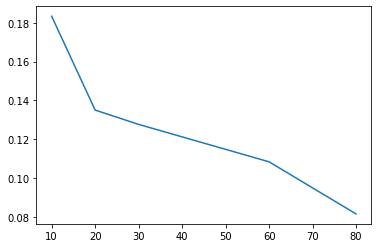

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

root='data/Linear Reflection'
NNxy=500
NNrz=250

co_rz_10d = np.mean(np.load(os.path.join(root,'10deg','co_rz_all.npy')), axis=0)
co_rz_20d = np.mean(np.load(os.path.join(root,'20deg','co_rz_all.npy')), axis=0)
co_rz_30d = np.mean(np.load(os.path.join(root,'30deg','co_rz_all.npy')), axis=0)
co_rz_60d = np.mean(np.load(os.path.join(root,'60deg','co_rz_all.npy')), axis=0)
co_rz_80d = np.mean(np.load(os.path.join(root,'80deg','co_rz_all.npy')), axis=0)


co_ss_10d = np.sum(co_rz_10d[:NNrz-1,:NNrz-1])
co_ss_20d = np.sum(co_rz_20d[:NNrz-1,:NNrz-1])
co_ss_30d = np.sum(co_rz_30d[:NNrz-1,:NNrz-1])
co_ss_60d = np.sum(co_rz_60d[:NNrz-1,:NNrz-1])
co_ss_80d = np.sum(co_rz_80d[:NNrz-1,:NNrz-1])

x=np.array([10,20,30,60,80])
diff=x[1:]-x[:-1]
diff=np.append(diff,[10])
data=[co_ss_10d,co_ss_20d,co_ss_30d,co_ss_60d,co_ss_80d]
sum_all=np.sum(data*diff/10)

plt.plot(x,data/sum_all)
plt.show()



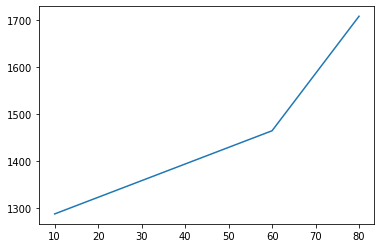

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

root='data/Linear 2'
NNxy=500
NNrz=250

co_rz_10d =np.mean(np.abs(np.load(os.path.join(root,'10deg','co_rz_all.npy'))), axis=0)
co_rz_60d =np.mean(np.abs(np.load(os.path.join(root,'60deg','co_rz_all.npy'))), axis=0)
co_rz_80d =np.mean(np.abs(np.load(os.path.join(root,'89deg','co_rz_all.npy'))), axis=0)

# print(co_rz_80d[NNrz-2,NNrz-2])
co_ss_10d = np.sum(co_rz_10d)
co_ss_60d = np.sum(co_rz_60d)
co_ss_80d = np.sum(co_rz_80d)

x=np.array([10,60,80])
diff=x[1:]-x[:-1]
diff=np.append(diff,[10])
data=[co_ss_10d,co_ss_60d,co_ss_80d]
sum_all=np.sum(data*diff/10)

plt.plot(x,data)
plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


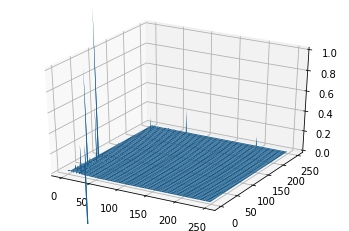

In [23]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%load_ext autoreload
%autoreload 2

x=co_rz_10d
ctr=512
grid_size = NNrz
# x = np.sum(x, axis=0)
x=(x-x.mean())/x.std()
x=np.clip(x,0,1)

x[0,0]=0
x[grid_size-1,grid_size-1]=0
x[grid_size-2,grid_size-2]=0
 
x/=ctr
x=np.abs(co_rz_10d)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(grid_size), range(grid_size))  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X, Y, x)
ax.set_zlim(0, 1)
plt.show()

4258


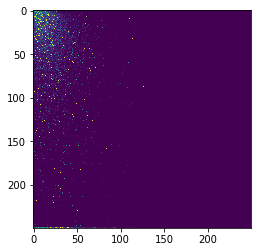

In [17]:
x=co_rz_10d
x[NNrz-1,NNrz-1]=0
x[NNrz-2,NNrz-2]=0
x[0,0]=0
print(np.argmax(x))
x=(x-x.mean())/x.std()
# x=x/x.max()
x=np.clip(x,0,1)
plt.imshow(x)
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


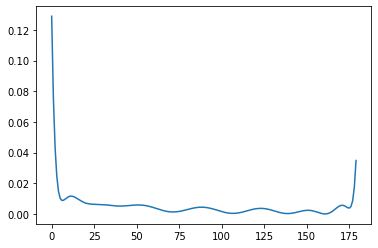

In [22]:
from photon_linear import *
from plot import *
from numpy import genfromtxt
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2
degree_divs=180
s1 = genfromtxt(f's1_pm_{degree_divs}.txt', delimiter=',')
s2 = genfromtxt(f's2_pm_{degree_divs}.txt', delimiter=',')
m11 = genfromtxt(f'm11_pm_{degree_divs}.txt', delimiter=',')
m12 = genfromtxt(f'm12_pm_{degree_divs}.txt', delimiter=',')
temp = 1j * s1[:, 2]
temp += s1[:, 1]
s1 = temp
temp = 1j * s2[:, 2]
temp += s2[:, 1]
s2 = temp
m11 = m11[:, 1]
m12 = m12[:, 1]
S=[1,1,0,0]
itheta_deg=np.linspace(0,179,180,dtype=np.int)
phi_partial=np.pi/3
I=m11[itheta_deg] + m12[itheta_deg] * (S[1] * cmath.cos(2 * phi_partial).real+S[2] * cmath.sin(2 * phi_partial).real) / S[0]
sum=np.sum(I)
plt.plot(I/sum)
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


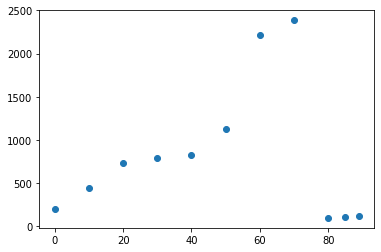

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2

root='data/Linear 3'
NNxy=500
NNrz=250

incident_degrees=[0,10,20,30,40,50,60,70,80]

co_rz_0d = np.mean(np.abs(np.load(os.path.join(root,'co', f'co_rz_linear_1.npy'))), axis=0)
co_rz_10d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_10.npy'))), axis=0)
co_rz_20d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_20.npy'))), axis=0)
co_rz_30d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_30.npy'))), axis=0)
co_rz_40d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_40.npy'))), axis=0)
co_rz_50d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_50.npy'))), axis=0)
co_rz_60d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_60.npy'))), axis=0)
co_rz_70d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_70.npy'))), axis=0)
co_rz_80d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_80.npy'))), axis=0)
co_rz_85d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_85.npy'))), axis=0)
co_rz_89d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_89.npy'))), axis=0)
# print(co_rz_80d[NNrz-2,NNrz-2])
co_ss_0d  = np.sum(co_rz_0d )
co_ss_10d = np.sum(co_rz_10d)
co_ss_20d = np.sum(co_rz_20d)
co_ss_30d = np.sum(co_rz_30d)
co_ss_40d = np.sum(co_rz_40d)
co_ss_50d = np.sum(co_rz_50d)
co_ss_60d = np.sum(co_rz_60d)
co_ss_70d = np.sum(co_rz_70d)
co_ss_80d = np.sum(co_rz_80d)
co_ss_85d = np.sum(co_rz_85d)
co_ss_89d = np.sum(co_rz_89d)

x=np.array([0,10,20,30,40,50,60,70,80,85,89])
diff=x[1:]-x[:-1]
diff=np.append(diff,[10])
data=np.array([co_ss_0d,co_ss_10d,co_ss_20d,co_ss_30d,co_ss_40d,co_ss_50d,co_ss_60d,co_ss_70d,co_ss_80d,co_ss_85d,co_ss_89d])
# data=1/data
sum_all=np.sum(data*diff/10)

plt.plot(x,data,'o')
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


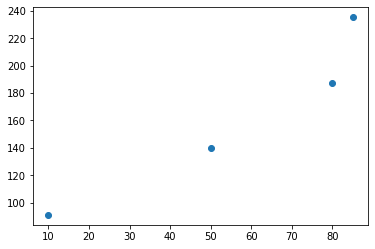

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2

root='data/Linear 4'
NNxy=500
NNrz=250

incident_degrees=[0,10,20,30,40,50,60,70,80]


co_rz_10d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_10.npy'))), axis=0)

co_rz_50d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_50.npy'))), axis=0)

co_rz_80d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_80.npy'))), axis=0)
co_rz_85d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_85.npy'))), axis=0)

# print(co_rz_80d[NNrz-2,NNrz-2])

co_ss_10d = np.sum(co_rz_10d)
co_ss_50d = np.sum(co_rz_50d)
co_ss_80d = np.sum(co_rz_80d)
co_ss_85d = np.sum(co_rz_85d)

x=np.array([10,50,80,85])
diff=x[1:]-x[:-1]
diff=np.append(diff,[10])
data=np.array([co_ss_10d,co_ss_50d,co_ss_80d,co_ss_85d])
# data=1/data
sum_all=np.sum(data*diff/10)

plt.plot(x,data,'o')
plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Ali\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


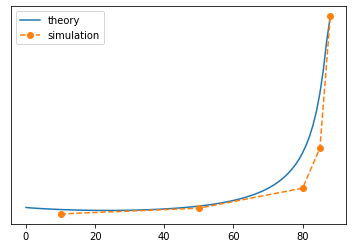

In [14]:
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
 
%matplotlib inline
%load_ext autoreload
%autoreload 2

root='data/Linear 6'
NNxy=500
NNrz=250

incident_degrees=incident_degrees=[10,50,80,85]


co_rz_10d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_10.npy'))), axis=0)
co_rz_50d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_50.npy'))), axis=0)
co_rz_80d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_80.npy'))), axis=0)
co_rz_85d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_85.npy'))), axis=0)
co_rz_89d =np.mean(np.abs(np.load(os.path.join(root,'co',f'co_rz_linear_89.npy'))), axis=0)

reflection_10d =np.mean(np.abs(np.load(os.path.join(root,'reflection',f'reflection_10.npy'))), axis=0)
reflection_50d =np.mean(np.abs(np.load(os.path.join(root,'reflection',f'reflection_50.npy'))), axis=0)
reflection_80d =np.mean(np.abs(np.load(os.path.join(root,'reflection',f'reflection_80.npy'))), axis=0)
reflection_85d =np.mean(np.abs(np.load(os.path.join(root,'reflection',f'reflection_85.npy'))), axis=0)
reflection_89d =np.mean(np.abs(np.load(os.path.join(root,'reflection',f'reflection_89.npy'))), axis=0)
# print(co_rz_80d[NNrz-2,NNrz-2])

co_ss_10d = np.sum(co_rz_10d[NNrz-1,NNrz-1])
co_ss_50d = np.sum(co_rz_50d[NNrz-1,NNrz-1])
co_ss_80d = np.sum(co_rz_80d[NNrz-1,NNrz-1])
co_ss_85d = np.sum(co_rz_85d[NNrz-1,NNrz-1])
co_ss_89d = np.sum(co_rz_89d[NNrz-1,NNrz-1])

reflection_10d = np.sum(reflection_10d)
reflection_50d = np.sum(reflection_50d)
reflection_80d = np.sum(reflection_80d)
reflection_85d = np.sum(reflection_85d)
reflection_89d = np.sum(reflection_89d)

photon_intensity = 128*128
x=np.array([10,50,80,85,88])
diff=x[1:]-x[:-1]
diff=np.append(diff,[10])
data=np.array([co_ss_10d,co_ss_50d,co_ss_80d,co_ss_85d,co_ss_89d])
data2=np.array([reflection_10d,reflection_50d,reflection_80d,reflection_85d,reflection_89d])
# data=1/data
sum_all=np.sum(data*diff/photon_intensity)



degree_divs=180
s1 = genfromtxt(f's1_pm_{degree_divs}.txt', delimiter=',')
s2 = genfromtxt(f's2_pm_{degree_divs}.txt', delimiter=',')
m11 = genfromtxt(f'm11_pm_{degree_divs}.txt', delimiter=',')
m12 = genfromtxt(f'm12_pm_{degree_divs}.txt', delimiter=',')
temp = 1j * s1[:, 2]
temp += s1[:, 1]
s1 = temp
temp = 1j * s2[:, 2]
temp += s2[:, 1]
s2 = temp
m11 = m11[:, 1]
m12 = m12[:, 1]
theta = np.linspace(0,np.pi/2,int(degree_divs/2))
k0 = 2*np.pi/(633e-9)
n_m = 1
f=0.1
a=70-9
x_m=n_m*k0*a
gamma = 3/2*f/np.power(x_m,3)

theta=np.linspace(0,degree_divs/2-1,int(degree_divs/2))*np.pi/int(degree_divs)
theta_2 = np.linspace(degree_divs-1,0 ,int(degree_divs/2),dtype=np.int)
s_1_p = 1/2*(s1[0]+s1[theta_2])
s_2_p = 1/2*(s2[0]+s2[theta_2])
s_1_n = s1[0]-s1[theta_2]
s_2_n = s2[0]-s2[theta_2]

mu_te = 1+1j*gamma*s_1_n/np.power(np.cos(theta),2)
eps_te = 1+1j*gamma*(2*s_1_p - s_1_n*np.power(np.tan(theta),2))
mu_tm = 1+1j*gamma*(2*s_2_p-s_2_n*np.power(np.tan(theta),2))
eps_tm = 1+1j*gamma*s_2_n/np.power(np.cos(theta),2)

n_eff_te = np.sqrt(mu_te*eps_te)
n_eff_tm = np.sqrt(mu_tm*eps_tm)
n_eff=1+2j*gamma*s1[0]
k_z_i=k0
k_z_eff_te=n_eff_te*k0
k_z_eff_tm=n_eff_tm*k0

r_te = (mu_te*k_z_i - k_z_eff_te)/(mu_te*k_z_i + k_z_eff_te)
r_tm = (eps_tm*k_z_i - k_z_eff_tm)/(eps_tm*k_z_i + k_z_eff_tm)
sum = 0.5*(np.abs(r_te)**2+np.abs(r_tm)**2)
xx=np.linspace(0,89,int(degree_divs/2),dtype=np.int)
plt.plot(xx[:-1],r_tm[:-1]/r_tm[-2])
 

plt.plot(x,data/photon_intensity/(data[-1]/photon_intensity),'--o')
plt.yticks([], [])

plt.legend(['theory','simulation'])
plt.savefig('reflection.png')
plt.show()


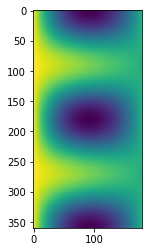

In [2]:
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
 
%matplotlib inline
%load_ext autoreload
%autoreload 2

root='data/Linear 6'
NNxy=500
NNrz=250
ddivs=180
pdivs=100

degree_divs=180
s1 = genfromtxt(f's1_pm_{degree_divs}.txt', delimiter=',')
s2 = genfromtxt(f's2_pm_{degree_divs}.txt', delimiter=',')
m11 = genfromtxt(f'm11_pm_{degree_divs}.txt', delimiter=',')
m12 = genfromtxt(f'm12_pm_{degree_divs}.txt', delimiter=',')
temp = 1j * s1[:, 2]
temp += s1[:, 1]
s1 = temp
temp = 1j * s2[:, 2]
temp += s2[:, 1]
s2 = temp
s11 = m11[:, 1]
s12 = m12[:, 1]

pf= np.zeros((ddivs, ddivs))
stokes=np.zeros(4)
stokes[0]=1
stokes[1]=1
stokes[2]=0
theta=np.linspace(0,2*np.pi,2*ddivs) 
thetas= np.zeros((ddivs,ddivs))
thetas = np.repeat(theta[np.newaxis,:],ddivs,axis=0)
ss11,tt=np.meshgrid(s11, theta)
ss12,tt=np.meshgrid(s12, theta)
pf = (ss11 * stokes[0] + ss12 * ( stokes[1] * np.cos(2 * tt) + stokes[2] * np.sin(2 * tt) ))
pf_sum=np.sum(pf)
pf /=pf_sum

pf_theta_cs = np.cumsum(np.sum(pf,axis=0))
pf_phi_cs = np.cumsum(np.sum(pf,axis=1))

theta_inv=np.zeros((ddivs,pdivs))
theta_inv[range(ddivs),(pf_theta_cs*(pdivs-1)).astype(np.int)]=1
theta_inv=np.argmax(theta_inv.T,axis=1)

phi_inv=np.zeros((2*ddivs,pdivs))
phi_inv[range(2*ddivs),(pf_phi_cs*(pdivs-1)).astype(np.int)]=1
phi_inv=np.argmax(phi_inv.T,axis=1)

plt.imshow(pf)
plt.show()

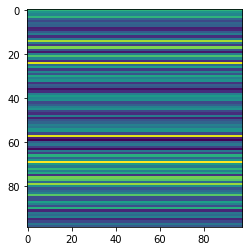

In [18]:
import itertools
N=10000
rands=phi_inv[(np.random.random(N)*(pdivs-1)).astype(np.int)]
bins=list(range(ddivs*2))
bin_indices = np.digitize(rands, bins)
bin_indices=np.sort(bin_indices)
phi_dist = np.array([(x, len(list(y))) for x, y in itertools.groupby(bin_indices)])
phi_dist=phi_dist[:,1]

rands=theta_inv[(np.random.random(N)*(pdivs-1)).astype(np.int)]
bins=list(range(ddivs))
bin_indices = np.digitize(rands, bins)
bin_indices=np.sort(bin_indices)
theta_dist = np.array([(x, len(list(y))) for x, y in itertools.groupby(bin_indices)])
theta_dist=theta_dist[:,1]

t,p=np.meshgrid(theta_dist, phi_dist)
x=p*t
x=x/np.sum(x)
plt.imshow(p)
plt.show()

C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


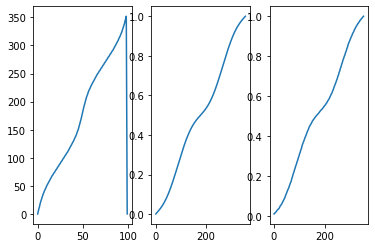

In [10]:
import itertools
N=10000
rands=phi_inv[(np.random.random(N)*(pdivs-1)).astype(np.int)]
bins=list(range(ddivs*2))
bin_indices = np.digitize(rands, bins)
bin_indices=np.sort(bin_indices)
Y = [(x, len(list(y))) for x, y in itertools.groupby(bin_indices)]
Y=np.array(Y)
# Y=np.cumsum(Y[:,0])
# plt.plot(np.cumsum(np.sum(pf,axis=0)))
fig,ax = plt.subplots(1,3)
ax[0].plot(phi_inv)
# ax[1].plot(np.cumsum(np.sum(pf,axis=0)))
ax[1].plot(np.cumsum(np.sum(pf,axis=1)))
x=Y[:,1]/np.sum(Y[:,1])
ax[2].plot(Y[:,0],np.cumsum(x))
fig.show()

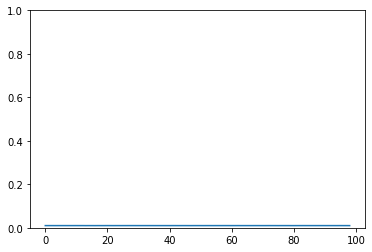

In [99]:
r=(np.random.random(10000000)*(pdivs-1)).astype(np.int)
bins1=list(range(pdivs))
bin_indices = np.digitize(r, bins1)
bin_indices=np.sort(bin_indices)
z = [(x,len(list(y))) for x, y in itertools.groupby(bin_indices)]
z=np.array(z)
x=z[:,1]/np.sum(z[:,1])
plt.plot(x)
plt.ylim([0,1])
plt.show()

C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


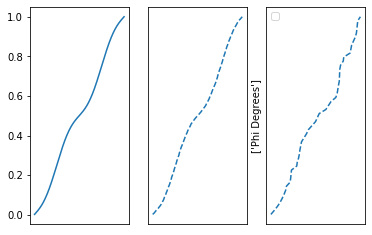

In [40]:
import itertools
N=10000
rands=phi_inv[(np.random.random(N)*(pdivs-1)).astype(np.int)]
bins=list(range(ddivs*2))
bin_indices = np.digitize(rands, bins)
bin_indices=np.sort(bin_indices)
Y = [(x, len(list(y))) for x, y in itertools.groupby(bin_indices)]
Y1=np.array(Y)
 
N=50
rands=phi_inv[(np.random.random(N)*(pdivs-1)).astype(np.int)]
bins=list(range(ddivs*2))
bin_indices = np.digitize(rands, bins)
bin_indices=np.sort(bin_indices)
Y = [(x, len(list(y))) for x, y in itertools.groupby(bin_indices)]
Y2=np.array(Y)

fig,ax = plt.subplots(1,3)
ax[0].plot(np.cumsum(np.sum(pf,axis=1)))
x=Y1[:,1]/np.sum(Y1[:,1])
ax[1].plot(Y1[:,0],np.cumsum(x),'--')
plt.legend(['Theoretical Probablity', 'Random Sampling'])
x=Y2[:,1]/np.sum(Y2[:,1])
ax[2].plot(Y2[:,0],np.cumsum(x),'--')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
# ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
plt.ylabel(['Phi Degrees'])
fig.show()


C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


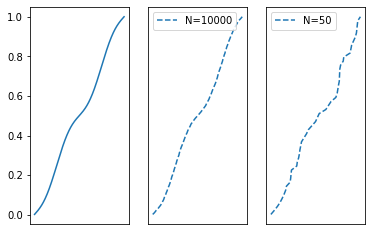

In [41]:
fig,ax = plt.subplots(1,3)
ax[0].plot(np.cumsum(np.sum(pf,axis=1)))
x=Y1[:,1]/np.sum(Y1[:,1])
ax[1].plot(Y1[:,0],np.cumsum(x),'--')
plt.legend(['Theoretical Probablity', 'Random Sampling'])
x=Y2[:,1]/np.sum(Y2[:,1])
ax[2].plot(Y2[:,0],np.cumsum(x),'--')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
# ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

ax[1].legend(['N=10000'])
ax[2].legend(['N=50'])
plt.savefig('phi_dist.png')
fig.show()


C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


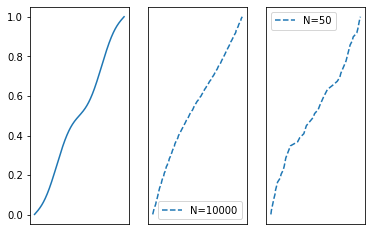

In [42]:
import itertools
N=10000
rands=theta_inv[(np.random.random(N)*(pdivs-1)).astype(np.int)]
bins=list(range(ddivs))
bin_indices = np.digitize(rands, bins)
bin_indices=np.sort(bin_indices)
Y = [(x, len(list(y))) for x, y in itertools.groupby(bin_indices)]
Y1=np.array(Y)
 
N=50
rands=theta_inv[(np.random.random(N)*(pdivs-1)).astype(np.int)]
bins=list(range(ddivs))
bin_indices = np.digitize(rands, bins)
bin_indices=np.sort(bin_indices)
Y = [(x, len(list(y))) for x, y in itertools.groupby(bin_indices)]
Y2=np.array(Y)

fig,ax = plt.subplots(1,3)
ax[0].plot(np.cumsum(np.sum(pf,axis=1)))
x=Y1[:,1]/np.sum(Y1[:,1])
ax[1].plot(Y1[:,0],np.cumsum(x),'--')
plt.legend(['Theoretical Probablity', 'Random Sampling'])
x=Y2[:,1]/np.sum(Y2[:,1])
ax[2].plot(Y2[:,0],np.cumsum(x),'--')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
# ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

ax[1].legend(['N=10000'])
ax[2].legend(['N=50'])
plt.savefig('theta_dist.png')
fig.show()

In [9]:
import numpy as np
A = np.array([[1,0,0,1],[1,0,0,-1],[0,1,1,0],[0,-1j,1j,0]]) 
Ai = np.linalg.inv(A)
j= np.array([[1,0],[0,1]])
x=A*np.tensordot(j,np.conj(j), axes=2)*Ai
x

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -0.-1.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j, -0.+1.j,  0.+0.j,  0.+0.j]])

In [10]:
Ai



array([[ 0.5+0.j ,  0.5+0.j ,  0. +0.j ,  0. +0.j ],
       [ 0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. +0.5j],
       [ 0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. -0.5j],
       [ 0.5+0.j , -0.5-0.j ,  0. -0.j ,  0. -0.j ]])